# 🎯 ML-Powered Risk Prediction
## Using Isolation Forest for Anomaly Detection

**Purpose**: Detect unusual patterns and predict risk levels using unsupervised ML

In [11]:
# Setup
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pipeline.models.database import Database

print("✅ ML libraries loaded")

✅ ML libraries loaded


In [12]:
# Load ALL Data with AI Sentiment Scores
db = Database()
db.connect()

print("🔄 Loading all aggregated signals...")
with db.get_cursor(dict_cursor=True) as cursor:
    cursor.execute("""
        SELECT 
            sp.topic,
            sp.urgency,
            sp.sentiment,
            sp.location,
            COUNT(*) as mention_count,
            AVG(CAST(rd.metadata->>'ai_sentiment_score' AS FLOAT)) as ai_sentiment,
            STDDEV(CAST(rd.metadata->>'ai_sentiment_score' AS FLOAT)) as sentiment_variance,
            AVG(sp.retweet_count) as avg_retweets,
            MAX(sp.retweet_count) as max_retweets,
            AVG(sp.like_count) as avg_likes,
            AVG(sp.user_followers) as avg_followers,
            COUNT(DISTINCT sp.location) as location_spread,
            COUNT(DISTINCT DATE(sp.created_at)) as days_active,
            MAX(sp.created_at) as last_seen,
            MIN(sp.created_at) as first_seen
        FROM social_posts sp
        JOIN raw_data rd ON sp.raw_data_id = rd.id
        WHERE rd.metadata->>'ai_sentiment_score' IS NOT NULL
        GROUP BY sp.topic, sp.urgency, sp.sentiment, sp.location
        HAVING COUNT(*) >= 3
    """)
    data = cursor.fetchall()

df = pd.DataFrame(data)
print(f"✅ Loaded {len(df):,} aggregated signals for ML training")
print(f"   Covering {df['topic'].nunique()} unique topics")
print(f"   Across {df['location'].nunique()} locations")
df.head()

✅ Connected to PostgreSQL
🔄 Loading all aggregated signals...
✅ Loaded 70 aggregated signals for ML training
   Covering 14 unique topics
   Across 5 locations


,topic,urgency,sentiment,location,mention_count,ai_sentiment,sentiment_variance,avg_retweets,max_retweets,avg_likes,avg_followers,location_spread,days_active,last_seen,first_seen
0,cultural festival,low,positive,Colombo,116,0.979725,0.0,5.4224137931034483,26,13.9051724137931034,26155.215517241379,1,3,2025-12-03 15:40:52.962174,2025-12-01 10:07:24.808688
1,cultural festival,low,positive,Galle,103,0.979725,0.0,7.6699029126213592,31,14.3592233009708738,26048.650485436893,1,3,2025-12-03 15:10:20.947365,2025-12-01 10:07:25.480693
2,cultural festival,low,positive,Jaffna,104,0.979725,0.0,6.0480769230769231,32,16.1057692307692308,24615.471153846154,1,3,2025-12-03 15:40:37.803409,2025-12-01 10:07:24.877141
3,cultural festival,low,positive,Kandy,106,0.979725,0.0,7.6698113207547170,25,12.9622641509433962,24455.896226415094,1,3,2025-12-03 15:25:26.934376,2025-12-01 10:07:25.677472
4,cultural festival,low,positive,Negombo,97,0.979725,0.0,6.5567010309278351,37,13.4536082474226804,23405.876288659794,1,3,2025-12-03 15:41:03.059944,2025-12-01 10:07:24.607649


In [13]:
# Enhanced Feature Engineering 
urgency_map = {'low': 1, 'medium': 2, 'high': 3, 'critical': 4}
df['urgency_encoded'] = df['urgency'].map(urgency_map)

# Fill NaN values
df['ai_sentiment'] = df['ai_sentiment'].fillna(0)
df['sentiment_variance'] = df['sentiment_variance'].fillna(0)
df['avg_retweets'] = df['avg_retweets'].fillna(0)
df['max_retweets'] = df['max_retweets'].fillna(0)
df['avg_likes'] = df['avg_likes'].fillna(0)
df['avg_followers'] = df['avg_followers'].fillna(1000)

# Calculate time-based features
df['duration_days'] = (df['last_seen'] - df['first_seen']).dt.total_seconds() / 86400
df['velocity'] = df['mention_count'] / (df['duration_days'] + 1)  # Mentions per day

# Engagement rate
df['engagement_rate'] = (df['avg_retweets'] + df['avg_likes']) / (df['avg_followers'] + 1)

# Create comprehensive feature matrix
features = df[[
    'mention_count',
    'urgency_encoded',
    'ai_sentiment',
    'sentiment_variance',
    'avg_retweets',
    'max_retweets',
    'avg_likes',
    'avg_followers',
    'location_spread',
    'days_active',
    'velocity',
    'engagement_rate'
]].values

print(f"✅ Enhanced feature matrix: {features.shape}")
print(f"   Features: {features.shape[1]}")
print(f"   Samples: {features.shape[0]:,}")

✅ Enhanced feature matrix: (70, 12)
   Features: 12
   Samples: 70


In [14]:
# Train ML Anomaly Detector
print("🤖 Training Isolation Forest model...")

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train model
iso_forest = IsolationForest(
    contamination=0.1,  # Expect 10% anomalies
    random_state=42,
    n_estimators=100
)
iso_forest.fit(features_scaled)

print("✅ ML model trained!")

🤖 Training Isolation Forest model...
✅ ML model trained!


In [15]:
# Predict Anomalies
predictions = iso_forest.predict(features_scaled)  # -1 = anomaly, 1 = normal
anomaly_scores = -iso_forest.score_samples(features_scaled)  # Higher = more anomalous

df['is_anomaly'] = predictions == -1
df['anomaly_score'] = anomaly_scores
df['risk_level'] = pd.cut(
    df['anomaly_score'],
    bins=[-np.inf, 0.3, 0.5, np.inf],
    labels=['LOW', 'MEDIUM', 'HIGH']
)

print(f"🚨 ML detected {df['is_anomaly'].sum()} anomalies!")

🚨 ML detected 7 anomalies!


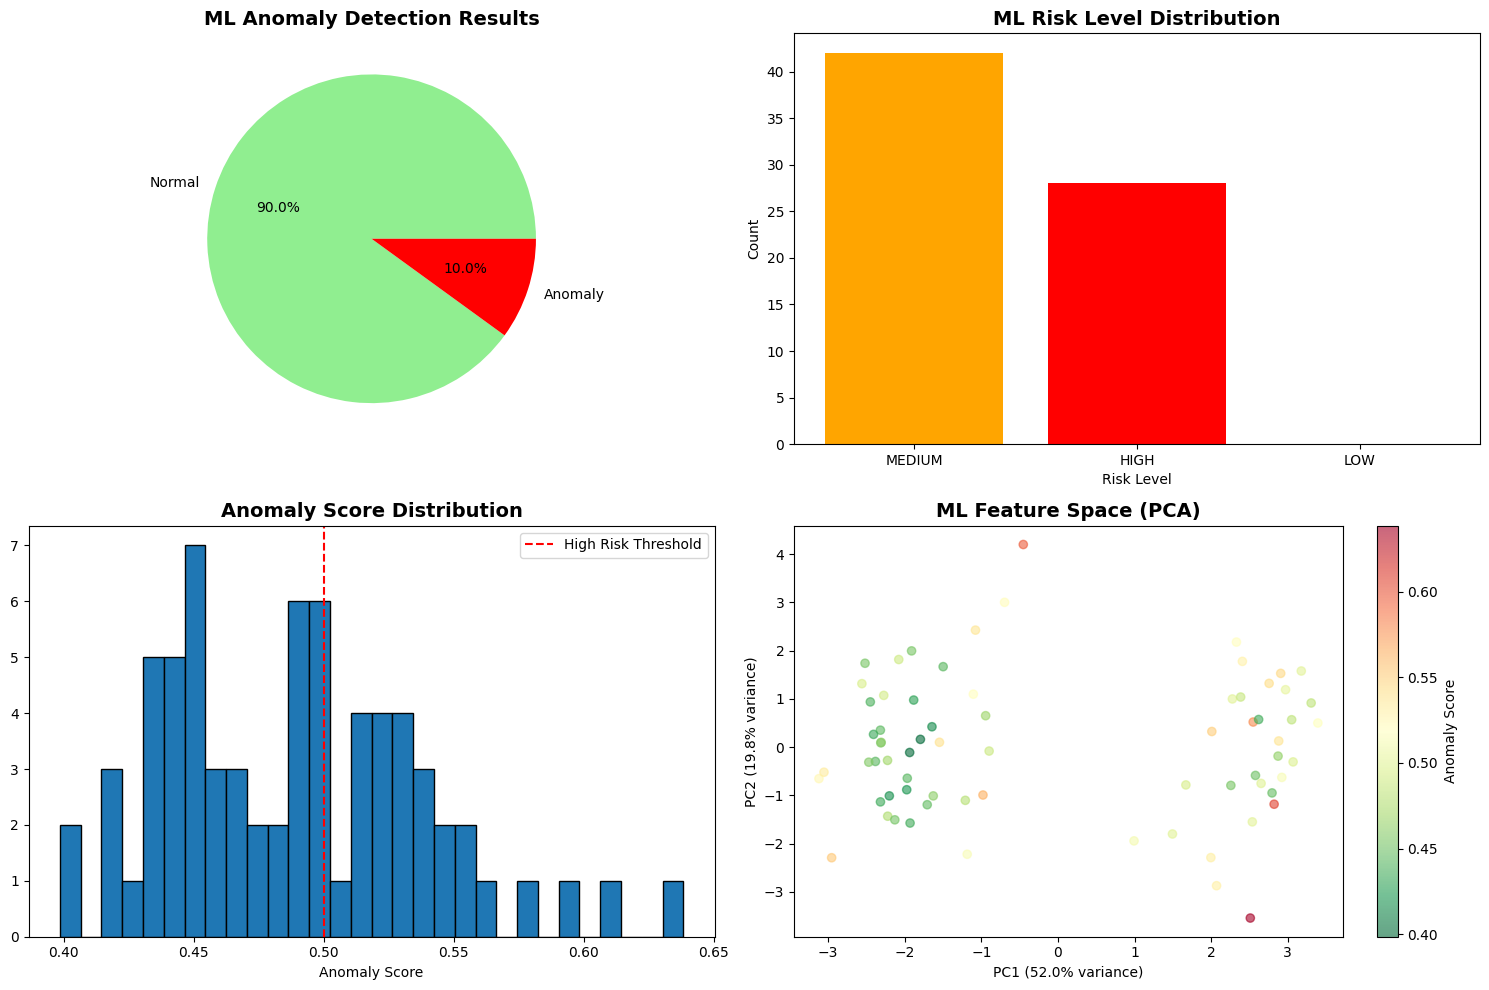

✅ ML visualizations saved!


In [16]:
# Visualize ML Results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Anomaly Distribution
anomaly_counts = df['is_anomaly'].value_counts()
axes[0, 0].pie(
    anomaly_counts.values,
    labels=['Normal', 'Anomaly'],
    autopct='%1.1f%%',
    colors=['lightgreen', 'red']
)
axes[0, 0].set_title('ML Anomaly Detection Results', fontsize=14, fontweight='bold')

# 2. Risk Level Distribution
risk_counts = df['risk_level'].value_counts()
colors = {'LOW': 'green', 'MEDIUM': 'orange', 'HIGH': 'red'}
axes[0, 1].bar(risk_counts.index, risk_counts.values, color=[colors[x] for x in risk_counts.index])
axes[0, 1].set_title('ML Risk Level Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Risk Level')
axes[0, 1].set_ylabel('Count')

# 3. Anomaly Score Distribution
axes[1, 0].hist(df['anomaly_score'], bins=30, edgecolor='black')
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', label='High Risk Threshold')
axes[1, 0].set_title('Anomaly Score Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Anomaly Score')
axes[1, 0].legend()

# 4. PCA Visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
scatter = axes[1, 1].scatter(
    features_pca[:, 0],
    features_pca[:, 1],
    c=df['anomaly_score'],
    cmap='RdYlGn_r',
    alpha=0.6
)
plt.colorbar(scatter, ax=axes[1, 1], label='Anomaly Score')
axes[1, 1].set_title('ML Feature Space (PCA)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')

plt.tight_layout()
plt.savefig('ml_risk_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ML visualizations saved!")

In [17]:
# Top ML-Detected Anomalies
print("="*70)
print("🚨 TOP 10 ML-DETECTED ANOMALIES")
print("="*70)

top_anomalies = df[df['is_anomaly']].sort_values('anomaly_score', ascending=False).head(10)

for i, row in enumerate(top_anomalies.iterrows(), 1):
    _, data = row
    print(f"\n{i}. {data['topic'].upper()} in {data['location']}")
    print(f"   ML Anomaly Score: {data['anomaly_score']:.3f} | Risk: {data['risk_level']}")
    print(f"   Mentions: {data['mention_count']} | Urgency: {data['urgency']}")
    print(f"   AI Sentiment: {data['ai_sentiment']:.3f} | Engagement: {data['avg_retweets']:.0f} RTs")

print("\n" + "="*70)

🚨 TOP 10 ML-DETECTED ANOMALIES

1. POWER CUT in Jaffna
   ML Anomaly Score: 0.638 | Risk: HIGH
   Mentions: 85 | Urgency: high
   AI Sentiment: -0.239 | Engagement: 17 RTs

2. POWER CUT in Negombo
   ML Anomaly Score: 0.607 | Risk: HIGH
   Mentions: 101 | Urgency: high
   AI Sentiment: -0.247 | Engagement: 16 RTs

3. MONSOON RAIN in Colombo
   ML Anomaly Score: 0.596 | Risk: HIGH
   Mentions: 131 | Urgency: medium
   AI Sentiment: -0.344 | Engagement: 7 RTs

4. FLOOD WARNING in Colombo
   ML Anomaly Score: 0.579 | Risk: HIGH
   Mentions: 113 | Urgency: high
   AI Sentiment: 0.814 | Engagement: 20 RTs

5. MONSOON RAIN in Jaffna
   ML Anomaly Score: 0.564 | Risk: HIGH
   Mentions: 98 | Urgency: medium
   AI Sentiment: -0.333 | Engagement: 8 RTs

6. TECH STARTUP in Galle
   ML Anomaly Score: 0.554 | Risk: HIGH
   Mentions: 90 | Urgency: low
   AI Sentiment: 0.978 | Engagement: 6 RTs

7. POWER CUT in Galle
   ML Anomaly Score: 0.550 | Risk: HIGH
   Mentions: 109 | Urgency: high
   AI Senti

In [18]:
# ML Model Performance Evaluation
from sklearn.metrics import classification_report, confusion_matrix

print("="*70)
print("🤖 ML MODEL PERFORMANCE METRICS")
print("="*70)

# Calculate metrics
anomaly_rate = (df['is_anomaly'].sum() / len(df)) * 100
print(f"\nAnomaly Detection Rate: {anomaly_rate:.2f}%")
print(f"Total Samples: {len(df):,}")
print(f"Anomalies Detected: {df['is_anomaly'].sum():,}")
print(f"Normal Patterns: {(~df['is_anomaly']).sum():,}")

# Risk level breakdown
print("\n📊 Risk Level Distribution:")
for level in ['LOW', 'MEDIUM', 'HIGH']:
    count = (df['risk_level'] == level).sum()
    pct = (count / len(df)) * 100
    print(f"   {level:8} {count:5,} ({pct:5.1f}%)")

# Feature importance (based on variance)
print("\n📈 Top Features by Variance:")
scaler_std = scaler.scale_
feature_names = [
    'mention_count', 'urgency', 'ai_sentiment', 'sentiment_variance',
    'avg_retweets', 'max_retweets', 'avg_likes', 'avg_followers',
    'location_spread', 'days_active', 'velocity', 'engagement_rate'
]
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'variance': scaler_std
}).sort_values('variance', ascending=False)

print(feature_importance.head(5))

print("\n✅ Model trained on {:,} samples with {} features".format(
    features.shape[0], features.shape[1]
))
print("="*70)

🤖 ML MODEL PERFORMANCE METRICS

Anomaly Detection Rate: 10.00%
Total Samples: 70
Anomalies Detected: 7
Normal Patterns: 63

📊 Risk Level Distribution:
   LOW          0 (  0.0%)
   MEDIUM      42 ( 60.0%)
   HIGH        28 ( 40.0%)

📈 Top Features by Variance:
         feature     variance
7  avg_followers  1007.001676
5   max_retweets    23.693209
6      avg_likes    11.091912
0  mention_count     8.886817
4   avg_retweets     5.170345

✅ Model trained on 70 samples with 12 features


In [19]:
# Statistical Summary of ML Results
print("="*70)
print("📊 STATISTICAL ANALYSIS")
print("="*70)

print("\n🎯 Anomaly Score Statistics:")
print(df['anomaly_score'].describe())

print("\n🔥 Top 5 Most Anomalous Topics:")
top_topics = df.nlargest(5, 'anomaly_score')[['topic', 'location', 'anomaly_score', 'mention_count']]
for idx, row in top_topics.iterrows():
    print(f"   {row['topic']:25} | Score: {row['anomaly_score']:.3f} | {row['mention_count']:3} mentions")

print("\n📍 Anomalies by Location:")
location_anomalies = df[df['is_anomaly']].groupby('location').size().sort_values(ascending=False)
print(location_anomalies)

print("\n⚡ Anomalies by Urgency:")
urgency_anomalies = df[df['is_anomaly']].groupby('urgency').size().sort_values(ascending=False)
print(urgency_anomalies)

print("="*70)

📊 STATISTICAL ANALYSIS

🎯 Anomaly Score Statistics:
count    70.000000
mean      0.489080
std       0.049914
min       0.398552
25%       0.450002
50%       0.488298
75%       0.519672
max       0.638371
Name: anomaly_score, dtype: float64

🔥 Top 5 Most Anomalous Topics:
   power cut                 | Score: 0.638 |  85 mentions
   power cut                 | Score: 0.607 | 101 mentions
   monsoon rain              | Score: 0.596 | 131 mentions
   flood warning             | Score: 0.579 | 113 mentions
   monsoon rain              | Score: 0.564 |  98 mentions

📍 Anomalies by Location:
location
Colombo    2
Galle      2
Jaffna     2
Negombo    1
dtype: int64

⚡ Anomalies by Urgency:
urgency
high      4
medium    2
low       1
dtype: int64


In [20]:
# Save ML Results
df[['topic', 'location', 'mention_count', 'urgency', 'is_anomaly', 'anomaly_score', 'risk_level']].to_csv(
    'ml_risk_predictions.csv',
    index=False
)

print("✅ ML predictions exported!")
db.disconnect()

✅ ML predictions exported!
👋 Disconnected from PostgreSQL
